In [116]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Import data

In [117]:
FILEPATHS = {
    "NER": {
        "train": "_sciner_models/summary/train_ner.json",
        "val": "_sciner_models/summary/val_ner.json",
    },
    "RE": {
        "train": "_scire_models/summary/train_re.json",
        "val": "_scire_models/summary/val_re.json",
    }
}

In [118]:
def print_progress(curr, full, prefix="", bar_size=30):    
    bar = int((curr+1)/full*bar_size)
    sys.stdout.write(f"\r{prefix}[{'='*bar}{' '*(bar_size-bar)}] {curr+1}/{full}")
    sys.stdout.flush()
    

In [119]:
filepath = FILEPATHS["NER"]["val"]
with open(filepath, 'r') as json_file:
    json_list = list(json_file)
data_ner = [json.loads(json_str) for json_str in json_list]
print(data_ner[0])

{'doc_key': 'SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96', 'sentences': [['This', 'paper', 'studies', 'FL', 'under', 'local', 'differential', 'privacy', 'constraints', '.'], ['They', 'identify', 'two', 'major', 'concerns', 'in', 'designing', 'practical', 'privacy', '-', 'preserving', 'FL', 'algorithms', ':', 'communication', 'efficiency', 'and', 'high\x02dimensional', 'compatibility', ',', 'and', 'develop', 'a', 'gradient', '-', 'based', 'learning', 'algorithm', 'sqSGD', 'that', 'addresses', 'both', 'concerns', '.'], ['They', 'improve', 'the', 'base', 'algorithm', 'in', 'two', 'ways', ':', 'First', ',', 'apply', 'a', 'gradient', 'subsampling', 'strategy', 'that', 'offers', 'simultaneously', 'better', 'training', 'performance', 'and', 'smaller', 'communication', 'costs', '.'], ['Secondly', ',', 'utilize', 'randomized', 'rotation', 'as', 'a', 'preprocessing', 'step', 'to', 'reduce', 'quantization', 'error', '.']], 'ner': [[], [], [], []], 'relations': [[], [], [], []], 'predicted_ner': [

In [120]:
result = data_ner[0]
all_sentences = [j for i in result["sentences"] for j in i]

for idx, sent in enumerate(result["sentences"]):
    print(f"Sentence {idx}: ")
    print(" ".join(sent))
    for pred_ner in result["predicted_ner"][idx]:
        start_idx = pred_ner[0]
        end_idx   = pred_ner[1]+1
        ent       = " ".join(all_sentences[start_idx:end_idx])
        print("\t{: >20}: {: <50}".format(pred_ner[2], ent))
    print()

Sentence 0: 
This paper studies FL under local differential privacy constraints .
	                Task: FL                                                
	 OtherScientificTerm: local differential privacy constraints            

Sentence 1: 
They identify two major concerns in designing practical privacy - preserving FL algorithms : communication efficiency and highdimensional compatibility , and develop a gradient - based learning algorithm sqSGD that addresses both concerns .
	              Method: privacy - preserving FL algorithms                
	              Metric: communication efficiency                          
	              Metric: highdimensional compatibility                    
	              Method: gradient - based learning algorithm sqSGD         

Sentence 2: 
They improve the base algorithm in two ways : First , apply a gradient subsampling strategy that offers simultaneously better training performance and smaller communication costs .
	             Generic: 

In [121]:
filepath = FILEPATHS["RE"]["val"]
with open(filepath, 'r') as json_file:
    json_list = list(json_file)
data_len = len(json_list)
data_re = [json.loads(json_str) for json_str in json_list]

In [122]:
result = data_re[2]
print(result)

{'doc_key': 'SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96', 'sentences': [['The', 'paper', 'proposed', 'a', 'differentially', 'private', 'training', 'algorithm', 'for', 'federated', 'learning', '.'], ['The', 'target', 'is', 'to', 'achieve', 'communication', 'reduction', 'while', 'keeping', 'differential', 'privacy', 'during', 'training', '.'], ['The', 'proposed', 'algorithm', 'adds', 'a', 'few', 'new', 'components', 'to', 'SGD', ',', 'including', 'a', 'privacy', 'mechanism', ',', 'a', 'random', 'rotation', 'to', 'reduce', 'quantization', 'error', ',', 'a', 'gradient', 'coordinate', 'selection', 'mechanism', 'to', 'reduce', 'communication', '/', 'computation', '.'], ['Experiments', 'with', 'high', '\\epsilon', 'local', 'differentially', 'privacy', 'guarantees', 'are', 'conducted', '.'], ['The', 'proposed', 'algorithm', 'outperforms', 'a', 'baseline', 'algorithm', '.']], 'ner': [[], [], [], [], []], 'relations': [[], [], [], [], []], 'predicted_ner': [[[4, 7, 'Method'], [9, 10, 'Method']]

In [123]:
all_sentences = [j for i in result["sentences"] for j in i]
for idx, sent in enumerate(result["sentences"]):
    print(f"Sentence {idx}: ")
    print(" ".join(sent))
    print(f"[Entity type]")
    for pred_ner in result["predicted_ner"][idx]:
        start_idx = pred_ner[0]
        end_idx   = pred_ner[1]+1
        ent       = " ".join(all_sentences[start_idx:end_idx])
        print("\t{: >20}: {: <50}".format(pred_ner[2], ent))
    print(f"[Triples]")
    for re in result["predicted_re"][idx][1]:
        s = " ".join(all_sentences[re[0][0]:(re[0][1]+1)])
        p = re[2]
        o = " ".join(all_sentences[re[1][0]:(re[1][1]+1)])
        print(f"({s}) ({p}) ({o})")
    
    print()

Sentence 0: 
The paper proposed a differentially private training algorithm for federated learning .
[Entity type]
	              Method: differentially private training algorithm         
	              Method: federated learning                                
[Triples]
(differentially private training algorithm) (USED-FOR) (federated learning)

Sentence 1: 
The target is to achieve communication reduction while keeping differential privacy during training .
[Entity type]
	                Task: communication reduction                           
	 OtherScientificTerm: differential privacy                              
[Triples]

Sentence 2: 
The proposed algorithm adds a few new components to SGD , including a privacy mechanism , a random rotation to reduce quantization error , a gradient coordinate selection mechanism to reduce communication / computation .
[Entity type]
	             Generic: algorithm                                         
	             Generic: components       

# Display entity and graph

In [133]:
import spacy
from spacy import displacy
from spacy.tokens import Span
from pathlib import Path

colors = {
    'Task':     "#DE3163", 
    "Method":   "#6495ED", 
    "Metric":   "#FF00FF", 
    "Material": "#40E0D0", 
    "Generic":  "#FFBF00",
    "OtherScientificTerm": "#9FE2BF", 
}
options = {"ents": colors.keys(), "colors": colors, "compact": True,}
nlp = spacy.load("en_core_web_sm")

def display_ent(doc, ents, savefile=None):
    doc = nlp(" ".join(doc))
    span_list = [Span(doc, start, end+1, ent_type) for start, end, ent_type in ents]
    doc.set_ents(span_list)
    ents = list(doc.ents)
    result = displacy.render(doc, style="ent", options=options)
    if not (savefile is None):
        output_path = Path("_output_imgs/"+savefile)
        output_path.open("w", encoding="utf-8").write(result)

In [134]:
def display_graph(doc, rels):
    pass

In [135]:
flatten_ner = [j for i in result["predicted_ner"] for j in i]
flatten_re  = [j for i in result["predicted_re"] for j in i[1]]
for i in result["predicted_re"]:
    print(i)

[0, [[[4, 7], [9, 10], 'USED-FOR']]]
[1, []]
[2, [[[39, 40], [43, 44], 'CONJUNCTION'], [[43, 44], [47, 48], 'USED-FOR'], [[43, 44], [51, 54], 'CONJUNCTION'], [[51, 54], [57, 59], 'USED-FOR'], [[28, 28], [35, 35], 'USED-FOR'], [[33, 33], [35, 35], 'USED-FOR'], [[33, 33], [28, 28], 'PART-OF'], [[43, 44], [33, 33], 'PART-OF'], [[51, 54], [33, 33], 'PART-OF'], [[39, 40], [33, 33], 'PART-OF']]]
[3, []]
[4, [[[74, 74], [77, 78], 'COMPARE']]]


In [136]:
display_ent(all_sentences, flatten_ner)

In [139]:
from graphviz import Digraph

def display_graph(all_sentences, flatten_ner, flatten_re, filename='kg'):
    dot = Digraph('Knowledge Graph', filename=filename)
    dot.attr('node', shape='box', style="filled")
    for ner in flatten_ner:
        ent = " ".join(all_sentences[ner[0]:ner[1]+1])
        dot.node(ent, color=colors[ner[2]])
    for re in flatten_re:
        s = " ".join(all_sentences[re[0][0]:(re[0][1]+1)])
        o = " ".join(all_sentences[re[1][0]:(re[1][1]+1)])
        p = re[2]
        dot.edge(s, o, label=p)
    dot.view()
    dot.render()



In [141]:
display_graph(all_sentences, flatten_ner, flatten_re, filename='img/kg')
    


In [148]:
def display_all(data):
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]
    flatten_re  = [j for i in data["predicted_re"] for j in i[1]]
    display_ent(all_sentences, flatten_ner)
    display_graph(all_sentences, flatten_ner, flatten_re, filename=f"img/{data['doc_key']}")

display_all(data_re[3])

# Statistics of IE from Summary

In [52]:
filepath = FILEPATHS["RE"]["val"]
with open(filepath, 'r') as json_file:
    json_list = list(json_file)
dataset = [json.loads(json_str) for json_str in json_list]
for key, val in dataset[0].items():
    print(key, val)

doc_key SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96
sentences [['This', 'paper', 'studies', 'FL', 'under', 'local', 'differential', 'privacy', 'constraints', '.'], ['They', 'identify', 'two', 'major', 'concerns', 'in', 'designing', 'practical', 'privacy', '-', 'preserving', 'FL', 'algorithms', ':', 'communication', 'efficiency', 'and', 'high\x02dimensional', 'compatibility', ',', 'and', 'develop', 'a', 'gradient', '-', 'based', 'learning', 'algorithm', 'sqSGD', 'that', 'addresses', 'both', 'concerns', '.'], ['They', 'improve', 'the', 'base', 'algorithm', 'in', 'two', 'ways', ':', 'First', ',', 'apply', 'a', 'gradient', 'subsampling', 'strategy', 'that', 'offers', 'simultaneously', 'better', 'training', 'performance', 'and', 'smaller', 'communication', 'costs', '.'], ['Secondly', ',', 'utilize', 'randomized', 'rotation', 'as', 'a', 'preprocessing', 'step', 'to', 'reduce', 'quantization', 'error', '.']]
ner [[], [], [], []]
relations [[], [], [], []]
predicted_ner [[[3, 3, 'Task'], [5, 8

In [81]:
import pandas as pd
col = ["paper_id", "summary"]
ent_types = ['Method', 'OtherScientificTerm', 'Task', 'Generic', 'Material', 'Metric']
rel_types = ['PART-OF', 'USED-FOR', 'FEATURE-OF', 'CONJUNCTION', 'EVALUATE-FOR', 'HYPONYM-OF', 'COMPARE']
# for ent_type in ent_types: col.append(f"ent_{ent_type}")
# for rel_type in rel_types: col.append(f"rel_{rel_type}")
ent_stat_df = pd.DataFrame(columns=col+ent_types)
rel_stat_df = pd.DataFrame(columns=col+rel_types)

for data in dataset:
    paper_id = data["doc_key"]
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]
    flatten_re  = [j for i in data["predicted_re"] for j in i[1]]

    # Count entity
    ent_count = {}
    for ent_type in ent_types: ent_count[ent_type]=0
    for ent in flatten_ner:
        ent_count[ent[2]] += 1
    ent_data = [paper_id, " ".join(all_sentences)] + list(ent_count.values())
    row_ent_df = pd.DataFrame([ent_data], columns=col+ent_types)
    ent_stat_df = pd.concat([ent_stat_df, row_ent_df], axis=0)
        
    # Count relation
    rel_count = {}
    for rel_type in rel_types: rel_count[rel_type]=0
    for rel in flatten_re:
        rel_count[rel[2]] += 1
    rel_data = [paper_id, " ".join(all_sentences)] + list(rel_count.values())
    row_rel_df = pd.DataFrame([rel_data], columns=col+rel_types)
    rel_stat_df = pd.concat([rel_stat_df, row_rel_df], axis=0)

,paper_id,summary,PART-OF,USED-FOR,FEATURE-OF,CONJUNCTION,EVALUATE-FOR,HYPONYM-OF,COMPARE
0,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,"In this paper , the authors address representa...",0,4,0,2,0,0,0


In [82]:
rel_stat_df

,paper_id,summary,PART-OF,USED-FOR,FEATURE-OF,CONJUNCTION,EVALUATE-FOR,HYPONYM-OF,COMPARE
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies FL under local differential...,0,1,1,1,1,0,0
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,This paper studies a low communication algorit...,0,10,1,2,1,0,0
0,SP:7f4b788b00a2a10bcd60351c3e04c8f597101e96,The paper proposed a differentially private tr...,4,5,0,2,0,0,1
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This submission works on the neural machine tr...,1,7,0,5,0,5,0
0,SP:632666b52c7c551d67fbbe70c06ed589c3a5e187,This paper proposes a method to introduce * * ...,1,7,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
0,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,This paper defines a set of learnable basis fu...,0,3,1,0,0,0,0
0,SP:18aaba3423e81e9437b509d1a5e24836ef5635f6,A typical Wavelet Transform is built through t...,0,2,1,0,0,0,0
0,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,This paper builds a new graph convolutional ne...,2,5,1,2,2,0,0
0,SP:3058e6bc5e8c62af325c214c9e1436d6cdf09204,The authors propose using non - Euclidean spac...,0,3,0,0,0,0,0


In [92]:
def count_num_paper(df):
    num_paper = df.groupby(['paper_id']).count()
    num_paper['num_paper'] = 1
    num_paper = num_paper.groupby(['summary']).count()
    return num_paper["num_paper"]
count_num_paper(rel_stat_df)

summary
2    194
3    352
4    410
5    104
Name: num_paper, dtype: int64

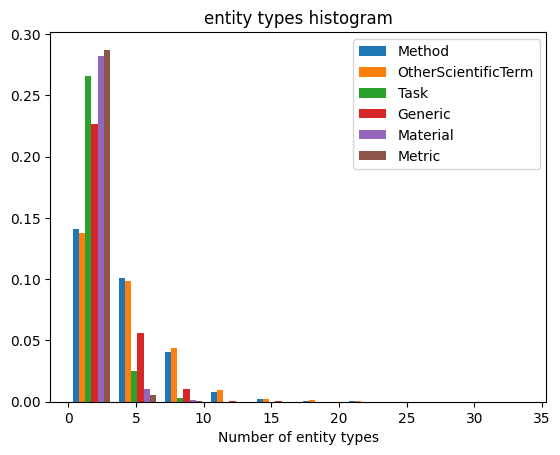

In [152]:
def hist_graph(df, cols, name_count):
    fig, ax = plt.subplots()
    ent_max = max([df[col].max() for col in cols]) 

    ax.hist(df[cols], density=True, histtype='bar', label=cols)
    ax.legend(prop={'size': 10})

    ax.set_xlabel(f"Number of {name_count}")
    ax.set_title(f"{name_count} histogram")

hist_graph(ent_stat_df, ent_types, name_count="entity types")

34

34